Importing required dependencies and dataset

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data.sampler import SubsetRandomSampler


transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

num_users = 500

In [2]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = len(train_data)//num_users, shuffle = True)


test_loader = torch.utils.data.DataLoader(test_data, batch_size =  100, shuffle = True)

In [3]:
import syft as sy

hook = sy.TorchHook(torch)

users = []
for i in range(1, num_users+1):
    users.append('user_' + str(i))
    
user_workers = []
for user in users:
    user_workers.append(sy.VirtualWorker(hook, id = user))
    

    



In [4]:
datasets = []
i = 0
for images, labels in train_loader:
    images_ptr = images.send(user_workers[i])
    labels_ptr = labels.send(user_workers[i])
    datasets.append((images_ptr, labels_ptr))
    i += 1

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        self.Dropout = nn.Dropout(0.01)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.Dropout(F.relu(self.fc1(x)))
        x = self.Dropout(F.relu(self.fc2(x)))
        x = self.Dropout(F.relu(self.fc3(x)))
        x = self.Dropout(F.relu(self.fc4(x)))
        
        x = self.fc5(x)
        
        return x
    
base_model = Model()
base_model


Model(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (Dropout): Dropout(p=0.01, inplace=False)
)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [7]:
trusted_aggregator = sy.VirtualWorker(hook, 'Trusted_aggregator')
trusted_aggregator

<VirtualWorker id:Trusted_aggregator #objects:6>

In [8]:
from syft.frameworks.torch.fl import utils


num_epochs = 50
criterion = nn.CrossEntropyLoss()

#base_model.to(device)
a = False
epoch_losses = []            
valid_losses = []

u_dict = {}

for e in range(1, num_epochs+1):
    epoch_loss = 0
    valid_loss = 0
    
    user_models = []
    for i in range(num_users):

        user_models.append(base_model.copy().send(user_workers[i]))
        
    user_optim = []
    for i in range(num_users):
        u_model = user_models[i]
        user_optim.append(torch.optim.Adam(u_model.parameters(), lr = 0.001))

    base_model = base_model.send(trusted_aggregator)
    
    
    for idx, (u_images, u_labels) in enumerate(datasets):
        
        optim = user_optim[idx]
        optim.zero_grad()
        
        u_model = user_models[idx]
        assert u_model.location == u_images.location
        
        #print(u_model.location, u_images)
        logits = u_model(u_images)
        
        #print(labels.shape, pred.shape)
        loss = criterion(logits, u_labels)
        #print(logits, loss)
        loss.backward()
        optim.step()
        u_model.move(trusted_aggregator)
        u_dict[idx] =  u_model
        #print(type(u_dict[idx]))
        
        
        
        epoch_loss += loss.get().item() * u_images.shape[0]
        
        
    
    
    base_model = utils.federated_avg(u_dict)
    base_model = base_model.get()
    
    for images, labels in test_loader:
        
        
        logits_v = base_model(images)
        loss_v = criterion(logits_v, labels)
        
        valid_loss += loss_v.item() * images.shape[0]
    
    
    
    epoch_losses.append(epoch_loss/60000)
    valid_losses.append(valid_loss/10000)
    
    print(f"Epoch: {e}/{num_epochs} Training Loss: {epoch_loss/60000} Validation Loss: {valid_loss/10000}")


Epoch: 1/50 Training Loss: 2.3053339314460755 Validation Loss: 2.2975712418556213
Epoch: 2/50 Training Loss: 2.2977345423698425 Validation Loss: 2.2873194551467897
Epoch: 3/50 Training Loss: 2.2875768070220945 Validation Loss: 2.275109930038452
Epoch: 4/50 Training Loss: 2.2754295830726625 Validation Loss: 2.254392046928406
Epoch: 5/50 Training Loss: 2.2548639225959777 Validation Loss: 2.2351288866996764
Epoch: 6/50 Training Loss: 2.2360536947250367 Validation Loss: 2.1979043078422547
Epoch: 7/50 Training Loss: 2.198648298740387 Validation Loss: 2.1665958976745605
Epoch: 8/50 Training Loss: 2.168125433921814 Validation Loss: 2.124027256965637
Epoch: 9/50 Training Loss: 2.125348801612854 Validation Loss: 2.0821541810035704
Epoch: 10/50 Training Loss: 2.0842912304401398 Validation Loss: 2.0253047847747805
Epoch: 11/50 Training Loss: 2.0269580512046814 Validation Loss: 1.9664076745510102
Epoch: 12/50 Training Loss: 1.9688868894577027 Validation Loss: 1.9111993968486787
Epoch: 13/50 Traini

Text(0, 0.5, 'Training Loss')

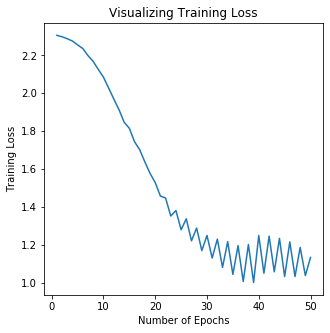

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (5,5))
plt.plot(range(1, num_epochs+1), epoch_losses) 
plt.title("Visualizing Training Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")

Text(0, 0.5, 'Validation Loss')

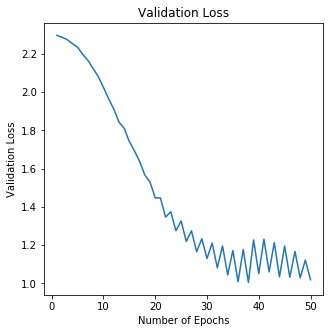

In [11]:
plt.figure(figsize = (5,5))          
plt.plot(range(1, num_epochs+1), valid_losses)
plt.title("Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Loss")

In [15]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

train_on_gpu = True


test_loss = 0.0

class_correct = [0. for i in range(10)]
class_total = [0. for i in range(10)]

base_model.eval()                                                        


for (images, labels) in test_loader:
    
    
    
    logits = base_model(images)
    
    loss = criterion(logits, labels)
    
    test_loss += loss.item()*images.size(0)
    
    pred_prob = F.softmax(logits)                               
    
    _, predicted_class = pred_prob.max(1)                       
    
    correct_tensor = predicted_class.eq(labels.data.view_as(predicted_class))
    
    correct = np.squeeze(correct_tensor.numpy()) 
    
    batch_size = labels.size(0)
    
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):                                                              
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (                           
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.011241

Test Accuracy of     0: 83% (823/980)
Test Accuracy of     1: 88% (1002/1135)
Test Accuracy of     2: 68% (710/1032)
Test Accuracy of     3: 80% (815/1010)
Test Accuracy of     4: 81% (798/982)
Test Accuracy of     5: 11% (100/892)
Test Accuracy of     6: 72% (693/958)
Test Accuracy of     7: 64% (663/1028)
Test Accuracy of     8: 84% (822/974)
Test Accuracy of     9: 27% (277/1009)

Test Accuracy (Overall): 67% (6703/10000)
